## Others: MPC environment Learning

直接学习游戏环境

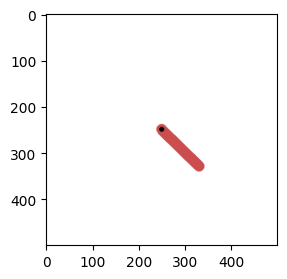

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step([action * 2])
    over = terminated or truncated

    # 偏移reward便于训练
    reward = (reward + 8) / 8
    
    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()


In [3]:
import torch

class FakeEnv(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.s = torch.nn.Sequential(
      torch.nn.Linear(4, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
    )
    
    self.next_state = torch.nn.Linear(64, 3)
    self.reward = torch.nn.Sequential(
      torch.nn.Linear(64, 1),
      torch.nn.Tanh(),
    )
    
  def forward(self, state, action):
    state = self.s(torch.cat([state, action], dim=1))
    return self.next_state(state) + state[:, :3], self.reward(state)
  
fake_env = FakeEnv()
fake_env(torch.randn(5, 3), torch.randn(5, 1))

(tensor([[ 0.0084, -0.0384, -0.0356],
         [ 0.1060,  0.0120,  0.0362],
         [ 0.0514,  0.0227, -0.0210],
         [ 0.0929,  0.0025,  0.0108],
         [ 0.0269, -0.0055, -0.0166]], grad_fn=<AddBackward0>),
 tensor([[0.0716],
         [0.0668],
         [0.0638],
         [0.0457],
         [0.0264]], grad_fn=<TanhBackward0>))

In [4]:
import random

# 环境学习阶段使用随机动作即可
def get_action(state):
  return random.normalvariate(mu=0, sigma=1)

get_action(None)

-0.7024876886597863

In [5]:
from IPython import display

#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    action = get_action(state)

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum

play()[-1]

77.1291064517978

In [6]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return len(self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      self.pool.extend(play()[0])
      
    # 保留最新N条数据
    self.pool = self.pool[-2_0000:]
    
  def sample(self):
    data = random.sample(self.pool, 64)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
    action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over
  
pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_23256\2246764732.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([0.9194921 , 0.39310846, 0.18502283], dtype=float32),
  0.06731753165078298,
  0.979166827440908,
  array([0.90937704, 0.41597277, 0.5000494 ], dtype=float32),
  False))

In [7]:
#训练
def train(epochs, test_epoch):
  fake_env.train()
  optimizer = torch.optim.Adam(fake_env.parameters(), lr=1e-3)
  loss_fn = torch.nn.MSELoss()

	# 共更新N轮数据
  for epoch in range(epochs):
    # 更新N条数据
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 模型计算
      p_next_state, p_reward = fake_env(state, action)
      
      loss_next_state = loss_fn(p_next_state, next_state)
      loss_reward = loss_fn(p_reward, reward)
      (loss_next_state + loss_reward).backward()
      optimizer.step()
      optimizer.zero_grad()

    if epoch % test_epoch == 0:
      print(epoch, len(pool), loss_next_state.item(), loss_reward.item(), play()[-1])

# 环境学习阶段
train(200, 20)

0 400 0.003181927604600787 0.0034012047108262777 31.8041189821367
20 4400 0.0007851131376810372 0.0004804400377906859 83.6320370555817
40 8400 0.00026375585002824664 0.00011461160465842113 65.4264554441749
60 12400 0.00023713901464361697 4.737813651445322e-05 25.866866852724083
80 16400 0.00020518794190138578 5.912105189054273e-05 32.15939923203713
100 20000 0.00036483866279013455 3.773035132326186e-05 68.62097613226628
120 20000 0.00024295394541695714 4.223985888529569e-05 101.87787300467411
140 20000 0.00017163337906822562 8.130764763336629e-05 86.48948391753653
160 20000 0.0001980587258003652 7.471700519090518e-05 79.3494763263025
180 20000 0.00019719100964721292 0.00022928501130081713 92.10102040634871


In [8]:
# 使用虚拟环境获取最优动作
def get_action(state):
  # 初始化N步动作的分布
  mu = torch.zeros(1, 15)
  sigma = torch.ones(1, 15)
  
  state = torch.FloatTensor(state).reshape(1, -1).repeat(50, 1)
  state_clone = state.clone()
  
  # 反复优化N次动作的分布
  for _ in range(5):
    # 根据N步动作的分布抽样生成N份动作链
    action = mu + torch.randn(50, 15) * sigma
    reward_sum = torch.zeros(50, 1)
    state = state_clone
    
    # 按顺序执行N步的动作,计算Q
    for i in range(15):
      state, reward = fake_env(state, action[:, i].unsqueeze(dim=1))
      reward_sum += reward * 0.95**i
      
    # 求分数最高的N份动作链
    sort = reward_sum.flatten().sort(descending=True).indices
    action = action[sort][:10]
    
    # 修正动作链的分布
    mu = 0.5 * mu + 0.5 * action.mean(dim=0, keepdim=True)
    sigma = 0.5 * sigma + 0.5 * action.std(dim=0, keepdim=True)
    
  # 返回最优动作
  return mu[0, 0].item()

get_action(torch.randn(1, 3))

1.107590675354004

In [9]:
# 动作学习阶段
train(10, 1)

0 20000 0.00010139610822079703 4.871291093877517e-05 183.53315529713532
1 20000 8.721261838218197e-05 2.8925816877745092e-05 184.24537246671989
2 20000 8.041139517445117e-05 5.4372339945985004e-05 184.00248252633259
3 20000 0.0001704087044345215 1.9289416741230525e-05 183.70960643420906
4 20000 5.855770723428577e-05 4.656168312067166e-05 153.47261320513527
5 20000 6.776364898541942e-05 7.72590356064029e-05 184.2846848241581
6 20000 0.0001712477533146739 0.0001044537712004967 169.04552849301615
7 20000 0.00016029147082008421 2.7275442334939726e-05 184.20373724024267
8 20000 0.00019186978170182556 2.9265347620821558e-05 183.96898582323325
9 20000 0.00011650632950477302 4.464131052372977e-05 184.03076229932825


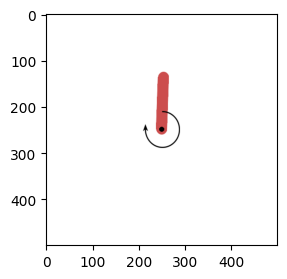

183.84983835128406

In [11]:
play(True)[-1]